In [1]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import keras

from keras.utils import np_utils
from keras.optimizers import Adam

import os
import numpy as np
import itertools

import cv2
import os
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Keypoint detection

https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

https://computer-vision-talks.com/2011-07-13-comparison-of-the-opencv-feature-detection-algorithms/

In [2]:
import cv2

DETECTOR_METHOD_FAST = "fast"
DETECTOR_METHOD_SIFT = "sift"
DETECTOR_METHOD_HARRIS = "harris"

DESCRIPTOR_METHOD_BRIEF = "brief"
DESCRIPTOR_METHOD_SIFT = "sift"

def get_image_description(img, threshold = 75, 
                          detector = DETECTOR_METHOD_FAST, 
                          descriptor = DESCRIPTOR_METHOD_SIFT,
                          drawDebug = False):
    img_array = image.img_to_array(img)
    img_grayscale = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    if detector == DETECTOR_METHOD_HARRIS:
        keypoints = []
        responses = cv2.cornerHarris(img_grayscale, 2, 3, 0.04)
        for x in (-responses.flatten()).argsort()[:threshold]:
            indices = np.unravel_index(x, responses.shape)
            keypoints.append(cv2.KeyPoint(indices[1], indices[0], 17))
    elif detector == DETECTOR_METHOD_SIFT:
        feat = cv2.xfeatures2d.SIFT_create(threshold)
        keypoints = feat.detect(img_grayscale, None)
    elif detector == DETECTOR_METHOD_FAST:
        feat = cv2.FastFeatureDetector_create(threshold)
        keypoints = feat.detect(img_grayscale, None)
    else:
        raise Exception("Unknown detector")

    if drawDebug:
        img_array_kp = img_array.copy().astype(np.uint8)
        cv2.drawKeypoints(img_array_kp, keypoints, img_array_kp, (0, 255, 0))
        plt.axis('off')
        plt.imshow(img_array_kp)
        plt.show()
    
    if descriptor == DESCRIPTOR_METHOD_SIFT:
        descriptor = cv2.xfeatures2d.SIFT_create()
    else:
        descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    return img_array, descriptor.compute(img_grayscale, keypoints)

def keypoint_match(pic, pattern, pic_desc, pattern_desc, drawDebug = False):
    bf = cv2.BFMatcher()
    matches = bf.match(pattern_desc[1], pic_desc[1])
    
    if drawDebug:
        plt.figure(figsize=(20, 20))
        plt.axis('off')
        plt.imshow(cv2.drawMatches(pattern, pattern_desc[0], pic, pic_desc[0], matches, 0,
                                   flags=0, matchColor=(0, 255, 0), singlePointColor=(255, 0, 0)).astype(np.uint8))
        plt.show()
    return matches

Найдём ключевые точки на изображениях:

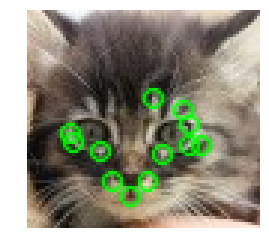

In [3]:
pattern, pattern_desc = get_image_description(image.load_img("cat.jpg"), drawDebug = True)

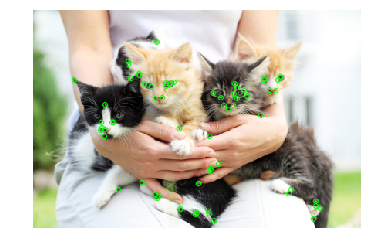

In [4]:
pic, pic_desc = get_image_description(image.load_img("cats.jpg"), drawDebug = True)

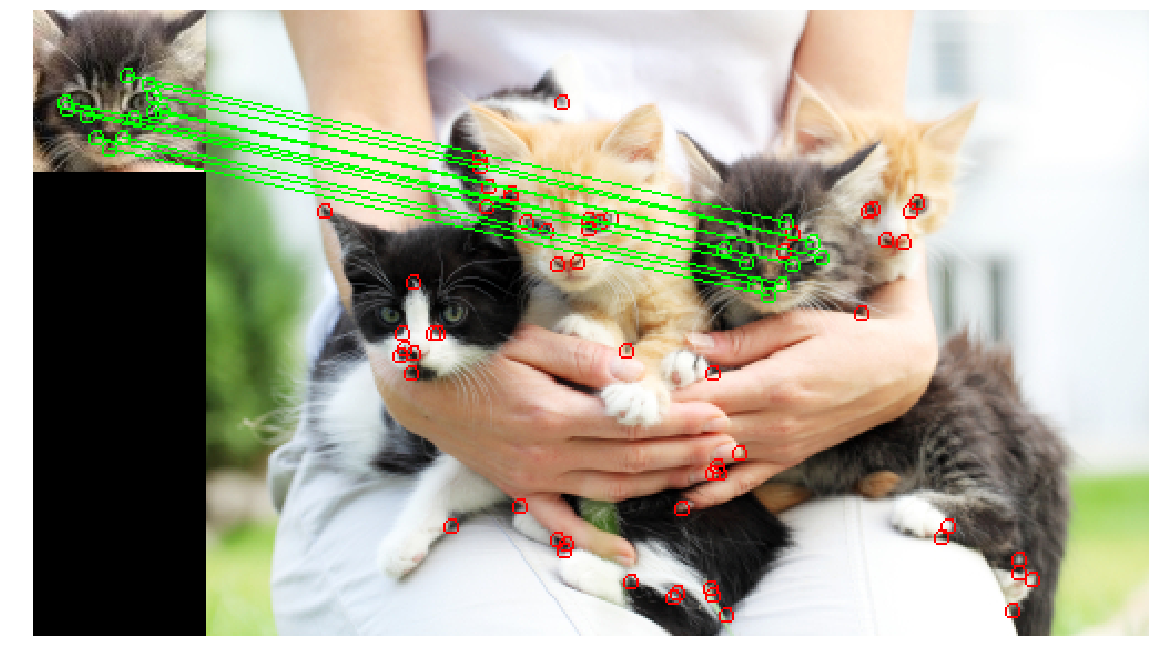

In [5]:
matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)

Сравним дескрипторы

In [6]:
for descriptor in [DESCRIPTOR_METHOD_SIFT, DESCRIPTOR_METHOD_BRIEF]:
    pattern, pattern_desc = get_image_description(
        image.load_img("button.jpg"), 5, detector=DETECTOR_METHOD_FAST, descriptor = descriptor)

    pic, pic_desc = get_image_description(
        image.load_img("sample_creative1.jpg"), 5, detector=DETECTOR_METHOD_FAST, descriptor = descriptor)
    # matches = keypoint_match(pic.astype(np.uint8), pattern_with_kp.astype(np.uint8), pic_desc, pattern_desc, True)
    # matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)

In [7]:
descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()

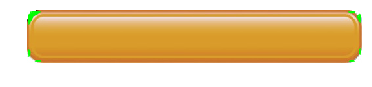

In [8]:
pattern, pattern_desc = get_image_description(image.load_img("button.jpg"), threshold=100, detector=DETECTOR_METHOD_HARRIS, drawDebug=True)

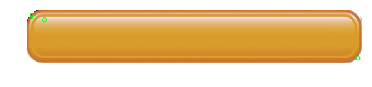

In [9]:
pattern, pattern_desc = get_image_description(image.load_img("button.jpg"), threshold=100, detector=DETECTOR_METHOD_SIFT, drawDebug=True)

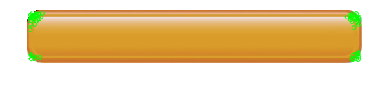

In [10]:
pattern, pattern_desc = get_image_description(image.load_img("button.jpg"), threshold=5, detector=DETECTOR_METHOD_FAST, drawDebug=True)

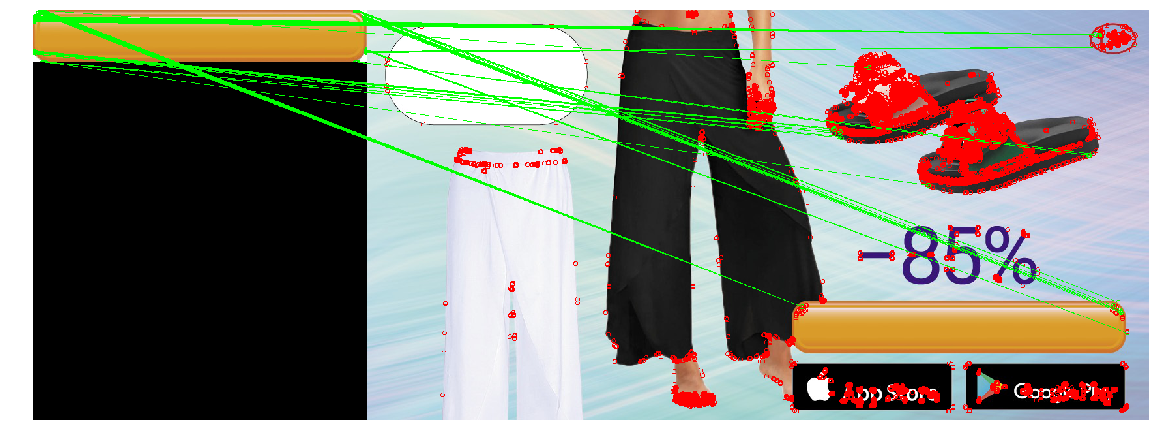

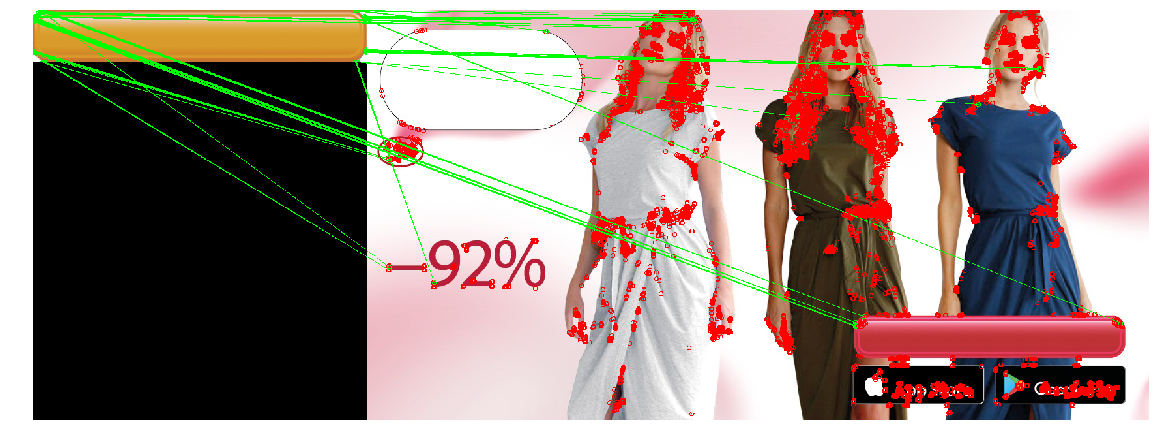

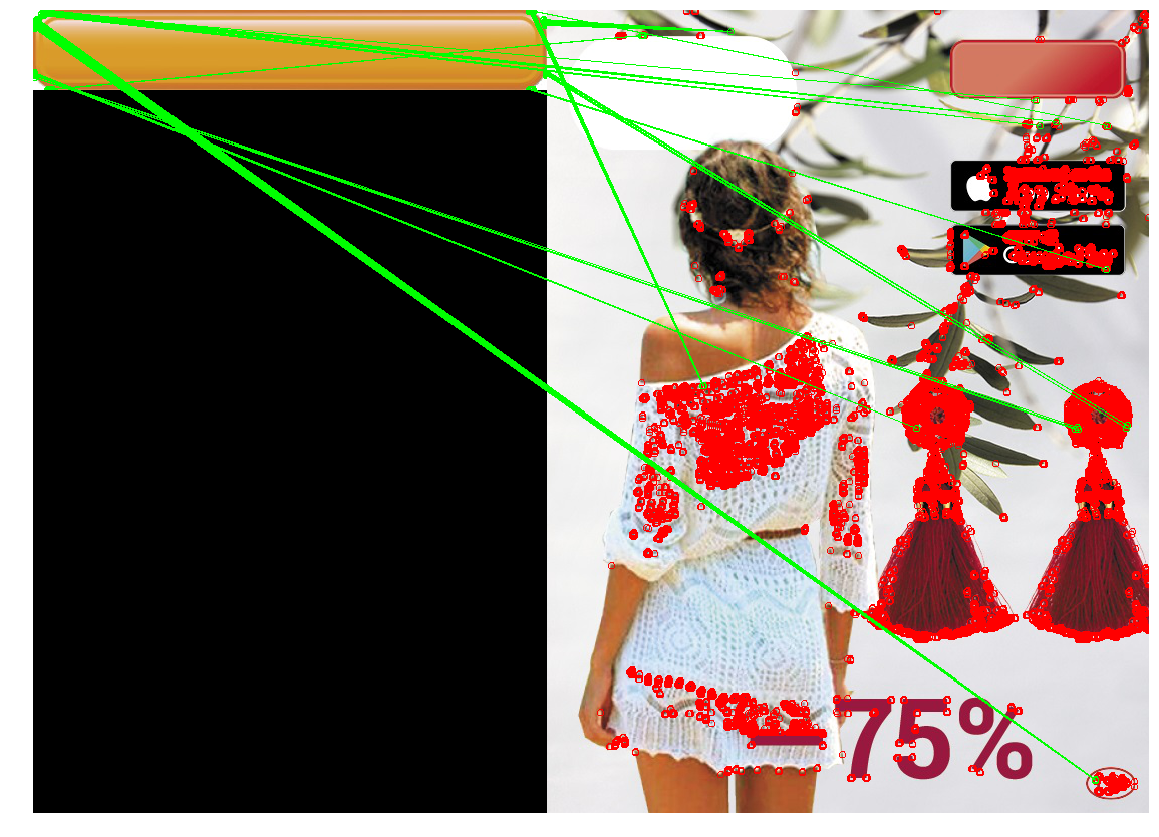

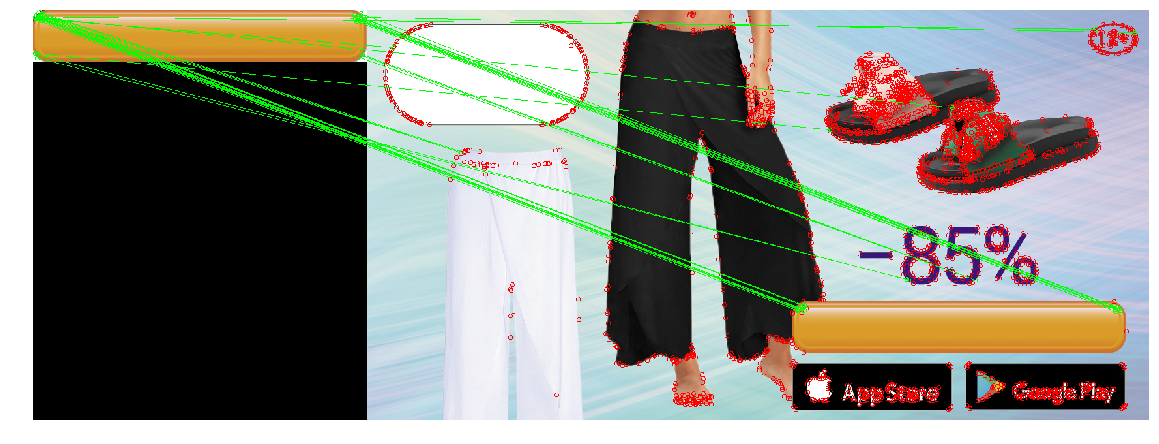

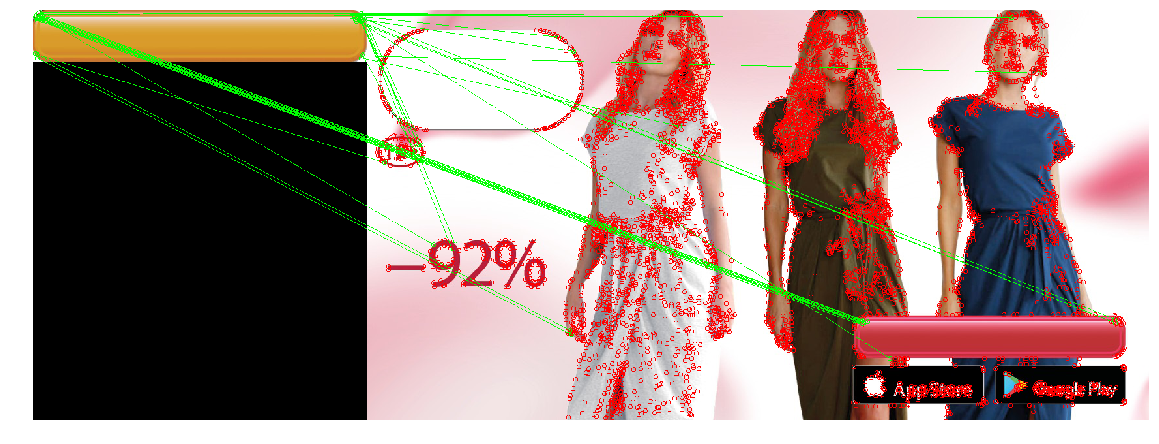

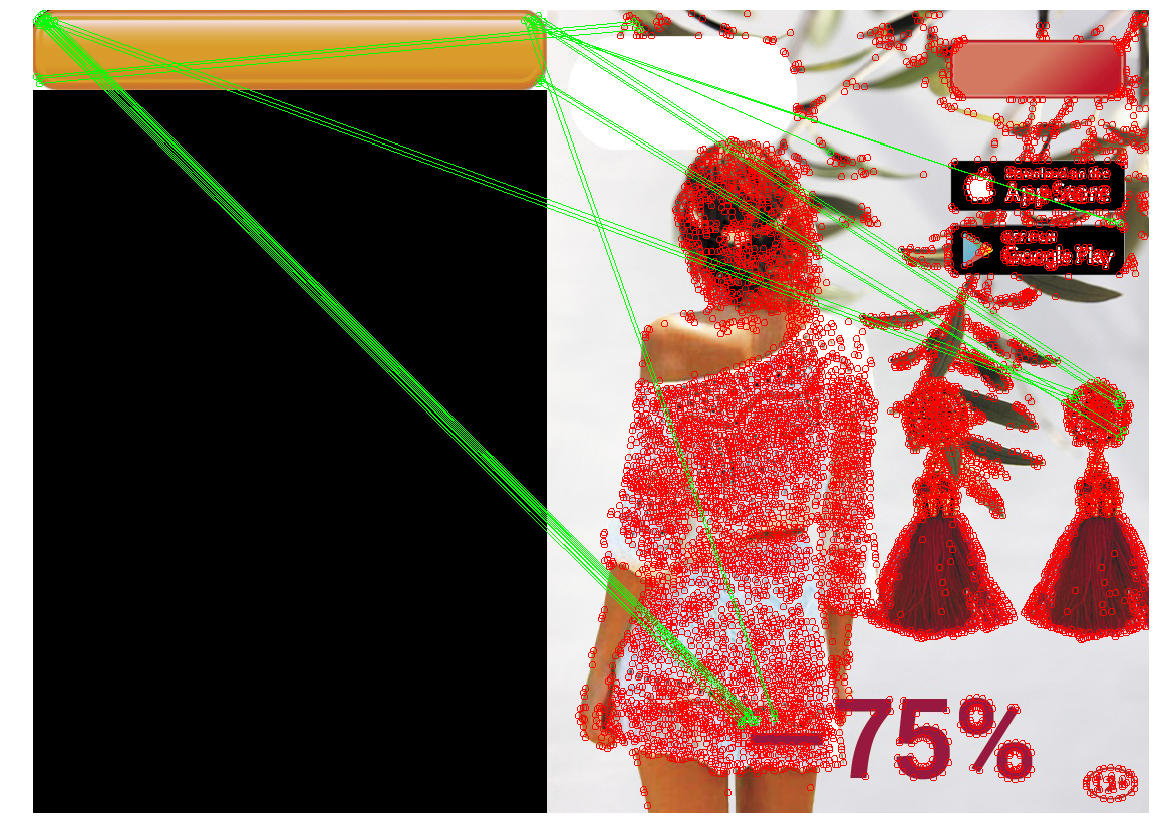

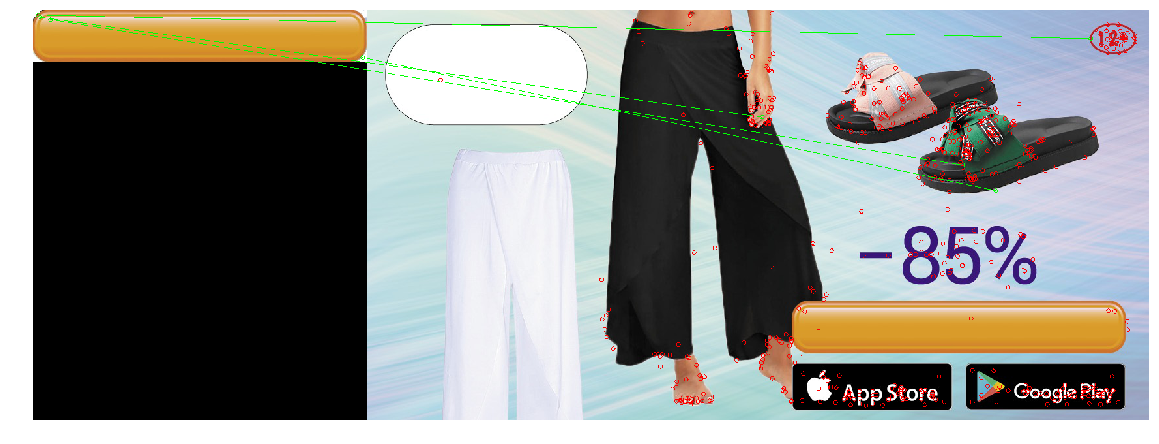

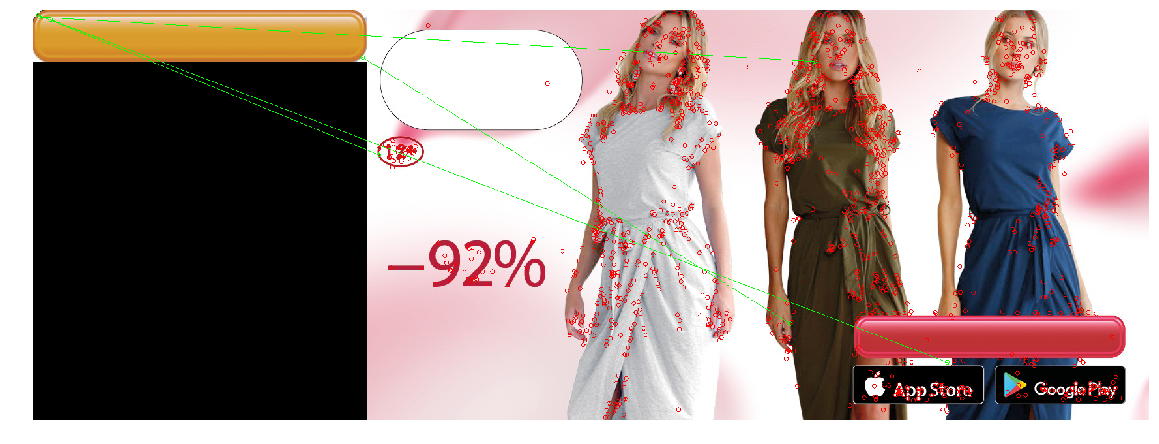

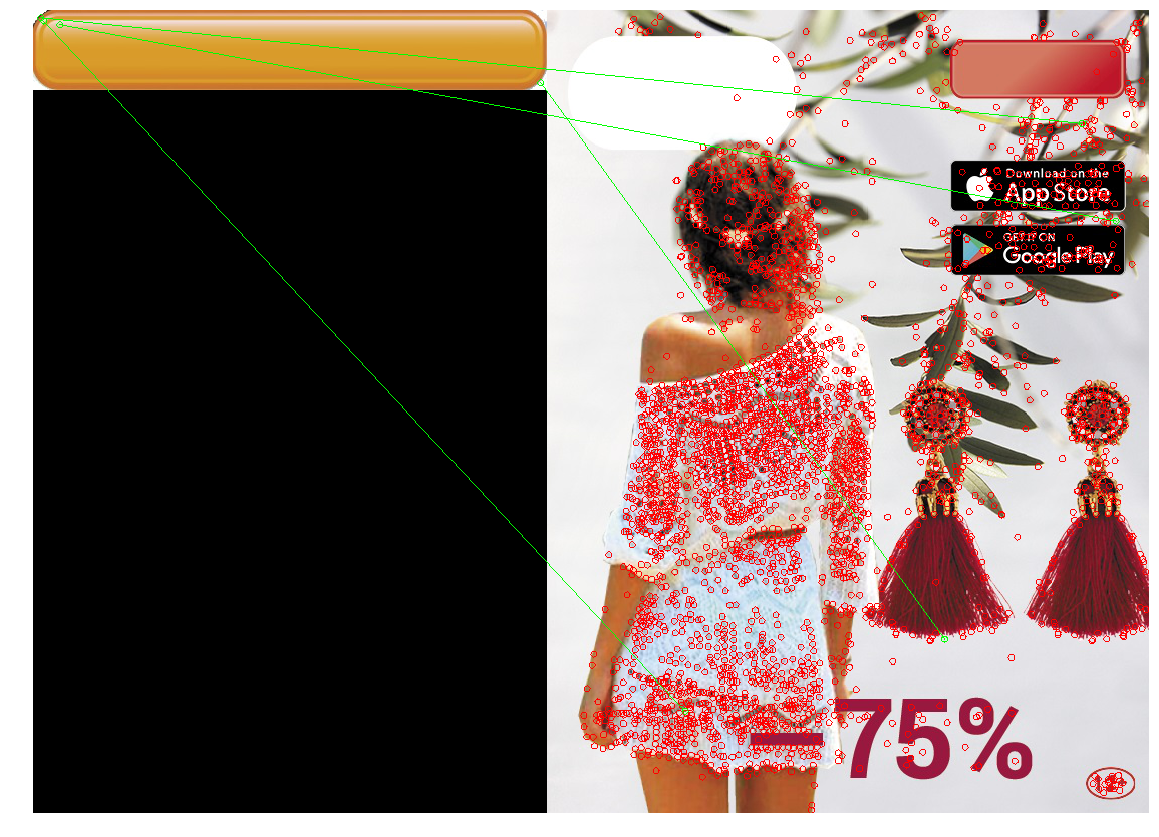

In [11]:
for detector, t_pattern, t_img in [(DETECTOR_METHOD_HARRIS, 100, 10000), (DETECTOR_METHOD_FAST, 10, 10), (DETECTOR_METHOD_SIFT, 100, 5000)]:
    for img in ["sample_creative1.jpg", "sample_creative2.jpg", "sample_creative3.jpg"]:
        pattern, pattern_desc = get_image_description(image.load_img("button.jpg"), t_pattern, detector=detector, drawDebug=False)
        pic, pic_desc = get_image_description(image.load_img(img), t_img, detector=detector)
        matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)
        plt.show()